# Adult Census Income
Predict whether income exceeds $50K/yr based on census data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
data = pd.read_csv('dataset.csv')

In [ ]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


# First: EDA

In [ ]:
print('Data shape:', data.shape)
print('-'*90)
print('Data info:', data.info())

Data shape: (45222, 14)
------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)




*   No nulls
*   Correct data types







In [ ]:
for i in data.columns:
     if np.dtype(data[i]):
        print("- ",i, ':',data[i].unique())
        print('-'*100)

-  age : [39 50 38 53 28 37 49 52 31 42 30 23 32 34 25 43 40 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 47 46 36 79 27 18 33 76 55 61 70 64 71 66 51 58
 26 17 60 90 75 65 77 62 63 67 74 72 69 68 73 81 78 88 80 84 83 85 82 86
 89 87]
----------------------------------------------------------------------------------------------------
-  workclass : [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Self-emp-inc' ' Without-pay']
----------------------------------------------------------------------------------------------------
-  education_level : [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' 7th-8th' ' Doctorate' ' Assoc-voc' ' Prof-school'
 ' 5th-6th' ' 10th' ' Preschool' ' 12th' ' 1st-4th']
----------------------------------------------------------------------------------------------------
-  education-num : [13.  9.  7. 14.  5. 10. 12.  4. 16. 11. 15.  3.  6.  1.  8.  2.]
-----------------------------------------------

No typos.

### Checking for duplicates

In [ ]:
sum(data.duplicated())

5982

In [ ]:
#Dropping duplicated rows
data.drop_duplicates(inplace = True)

Data is clean.

## Analyzing Features

####Categorical Features

In [ ]:
categorical_features = [col for col in data.columns if data[col].dtype == 'object']
categorical_features

['workclass',
 'education_level',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'income']

The target variable 'income'

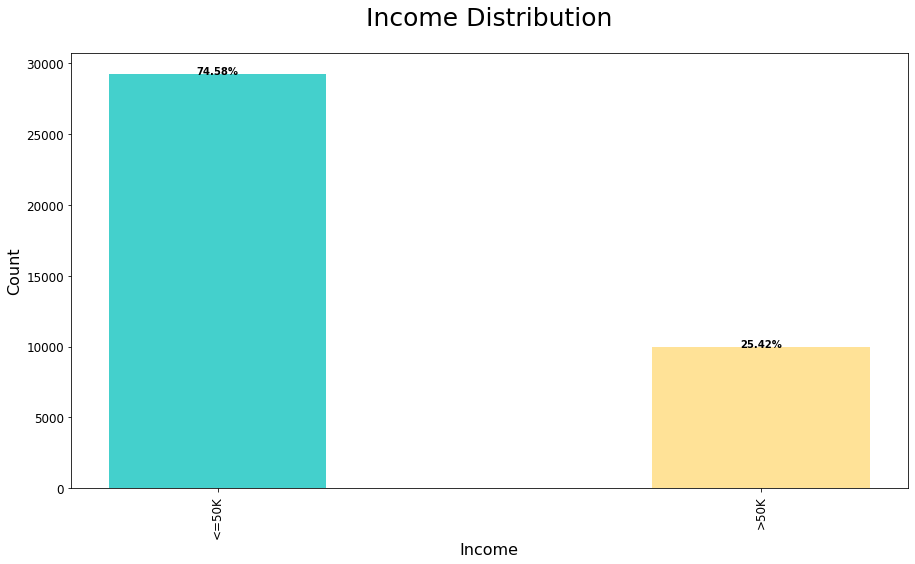

In [ ]:
#Checking for data imbalance
a = list(dict.fromkeys(data['income'].tolist()))
b = data['income'].value_counts()
percentage = round(data['income'].value_counts() * 100 / len(data['income']),2)

plt.figure(figsize = (15, 8));
colors = ['#44d0cc','#ffe297']
plt.bar(a, b, width=0.4, color=colors,);
plt.xlabel('Income', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Income Distribution',  fontsize=25, y=1.05)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
#Writing % above the bars
for a, b, percentage in zip(a, b, percentage):
      plt.text(a, b, str(percentage) + '%', ha='center', fontweight='bold')

plt.show();

This data is **imbalanced**.

In [ ]:
data.groupby(['sex','income'])['income'].count()

sex      income
 Female  <=50K     11519
         >50K       1624
 Male    <=50K     17746
         >50K       8351
Name: income, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


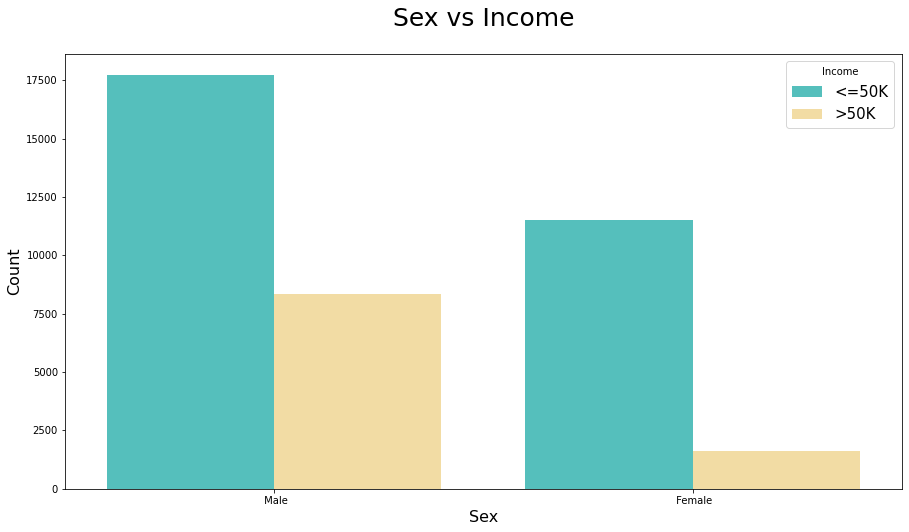

In [ ]:
plt.figure(figsize = (15, 8));
colors = ['#44d0cc','#ffe297','#44d0cc','#ffe297']
sns.countplot('sex',hue='income',data=data, palette=['#44d0cc','#ffe297'])
plt.title('Sex vs Income',  fontsize=25, y=1.05)
plt.xlabel('Sex', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(title="Income", prop={'size': 15})
plt.show()

*   Number of males in the data is more than the number of females.
*   Almost half of **males** have an income of **>50k**, while only quarter or less of **females** have an income of **>50k** 
So Generally, it looks like females are less paid. However, here we can't jump to an assumption that females are underpaid as there may be other factors as number of working hours, education, etc. that may contribute to this difference.

* Anyway, this feature seem to be important.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


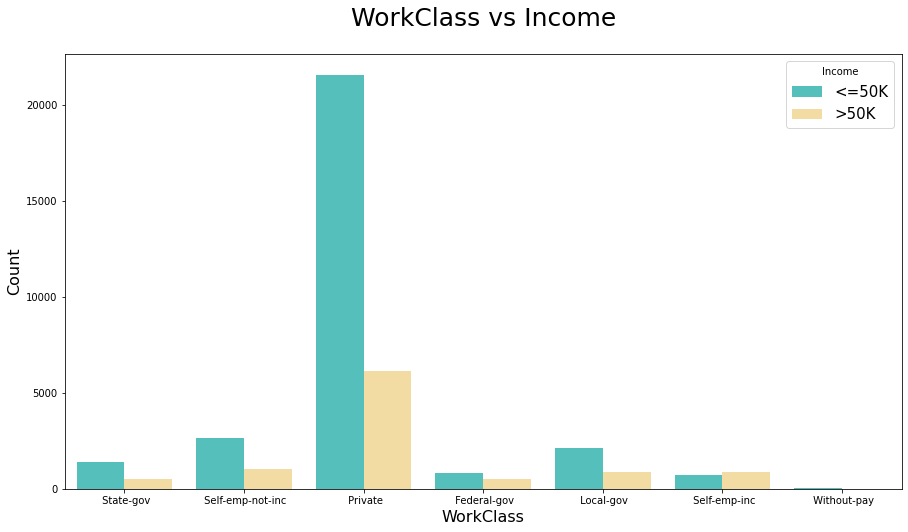

In [ ]:
plt.figure(figsize = (15, 8));
colors = ['#44d0cc','#ffe297','#44d0cc','#ffe297']
sns.countplot('workclass',hue='income',data=data, palette=['#44d0cc','#ffe297'])
plt.title('WorkClass vs Income',  fontsize=25, y=1.05)
plt.xlabel('WorkClass', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(title="Income", prop={'size': 15})++++++++++++++++++++++++++++++++++++++++
plt.show()

According to this plot we can conclude the following:

*   People who are **self employed in inc.** are more likely to get paid higher than the other work classes, followed by the **federal-gov**, thus having an income of **>50k.**
*   People who work in **private** work class are the least likely to have an income of >50k, their income is more likely to be **<50k**.




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


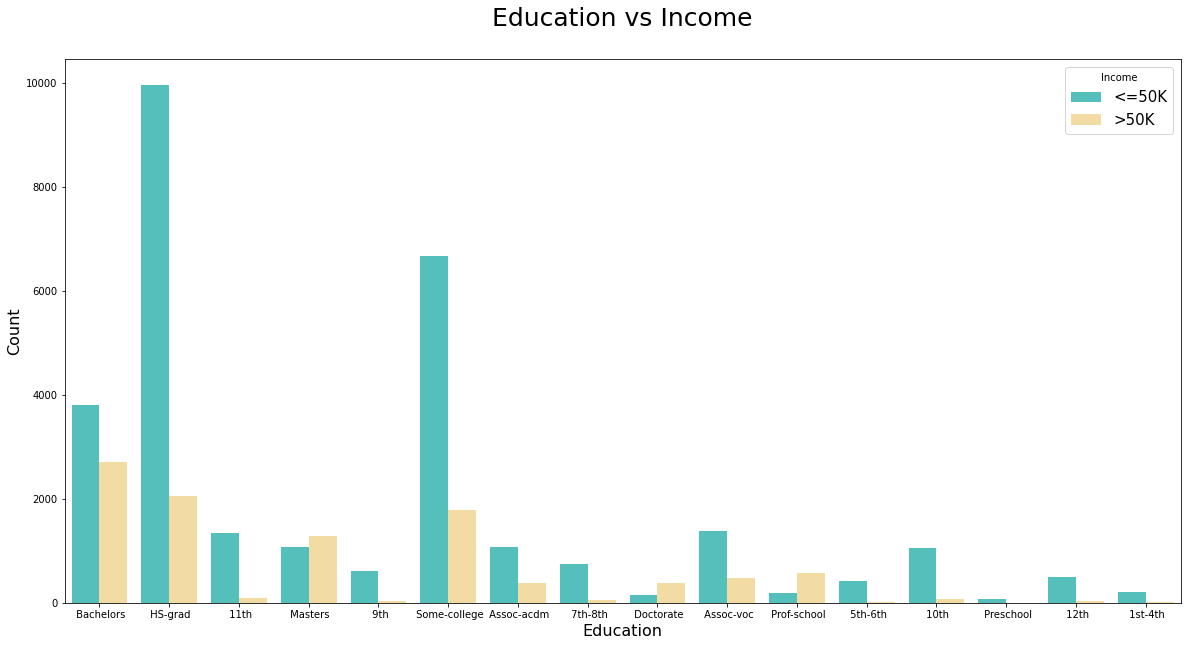

In [ ]:
plt.figure(figsize = (20, 10));
colors = ['#44d0cc','#ffe297','#44d0cc','#ffe297']
sns.countplot('education_level',hue='income',data=data, palette=['#44d0cc','#ffe297'])
plt.title('Education vs Income',  fontsize=25, y=1.05)
plt.xlabel('Education', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(title="Income", prop={'size': 15})
plt.show()

According to this plot we can conclude that:

*   Having **post-graduate degree**; masters, doctorate as well as attending a **professional school** affects the income in a positive way **>50k.**

* We can do some **feature engineering** here by grouping some of the levels together and this will be particularly useful as we have another continous feature (education-num) that is correlated with the education level (collinearity) so by changing this feature and creating new one, we may minimize this.






/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


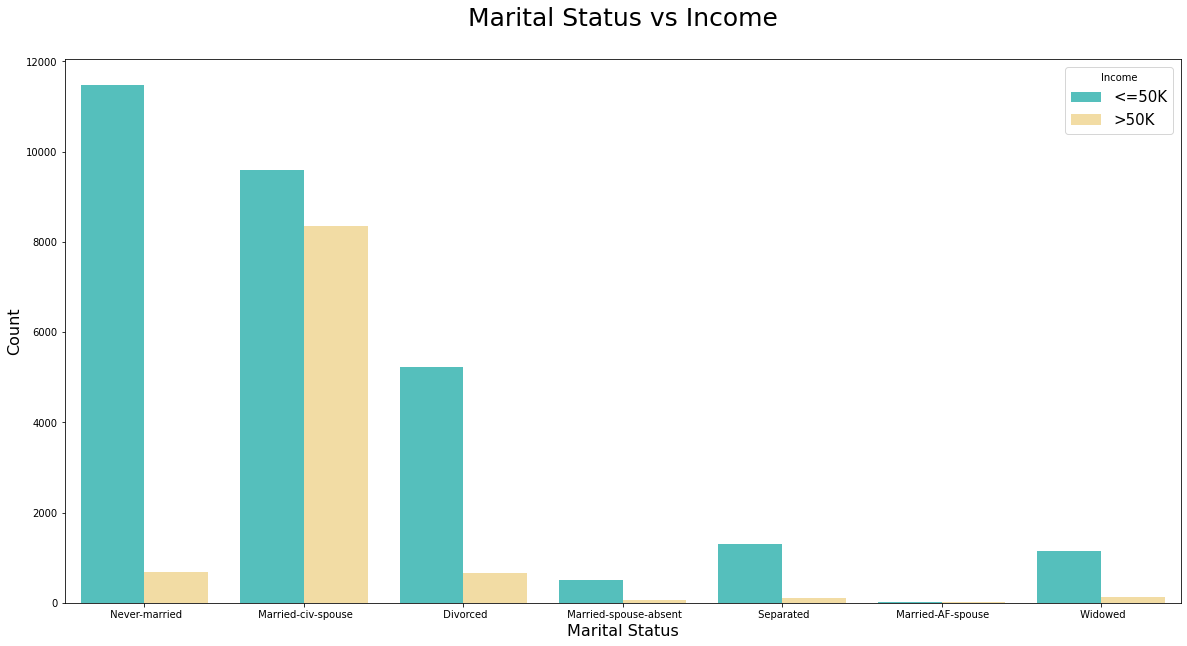

In [ ]:
plt.figure(figsize = (20, 10));
colors = ['#44d0cc','#ffe297','#44d0cc','#ffe297']
sns.countplot('marital-status',hue='income',data=data, palette=['#44d0cc','#ffe297'])
plt.title('Marital Status vs Income',  fontsize=25, y=1.05)
plt.xlabel('Marital Status', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(title="Income", prop={'size': 15})
plt.show()

* We can realize that a very big proportion (more than 75%) of married individuals have a income **>50k** 
* We can do some **feature engineering** here by grouping some of the status together.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


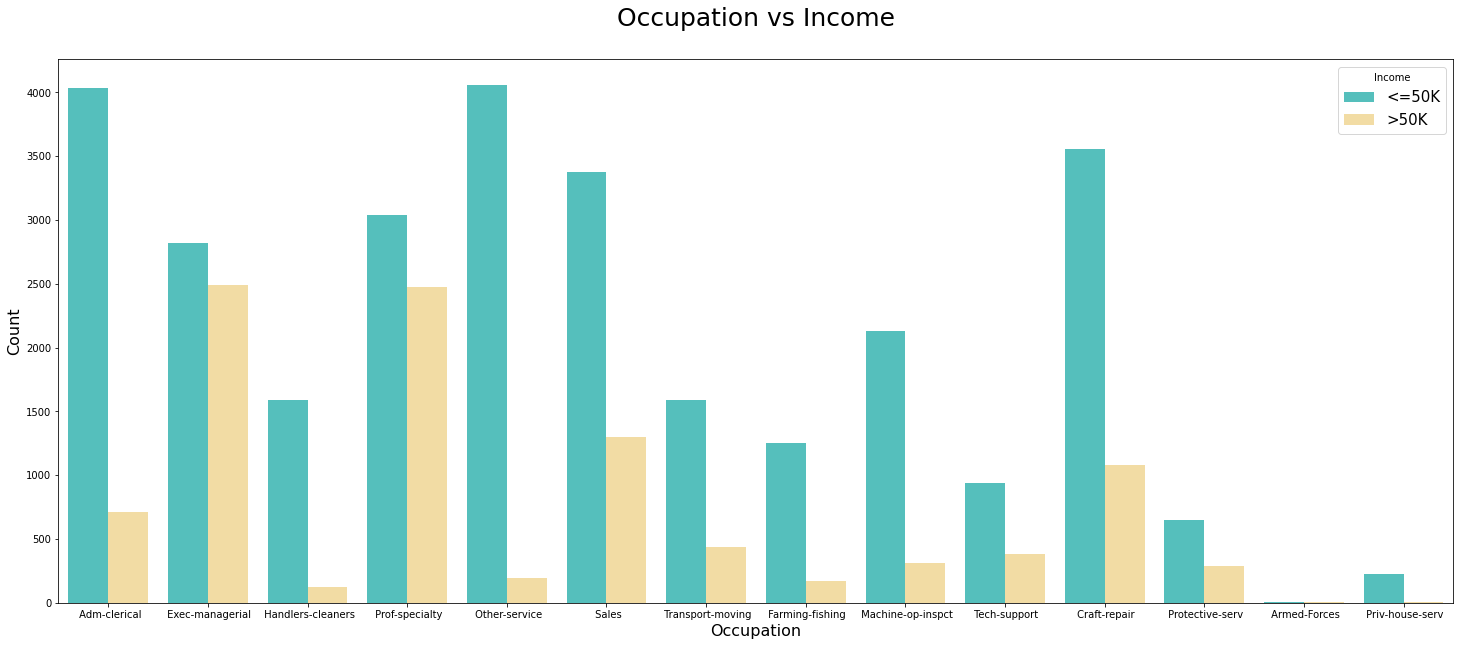

In [ ]:
plt.figure(figsize = (25, 10));
colors = ['#44d0cc','#ffe297','#44d0cc','#ffe297']
sns.countplot('occupation',hue='income',data=data, palette=['#44d0cc','#ffe297'])
plt.title('Occupation vs Income',  fontsize=25, y=1.05)
plt.xlabel('Occupation', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(title="Income", prop={'size': 15})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


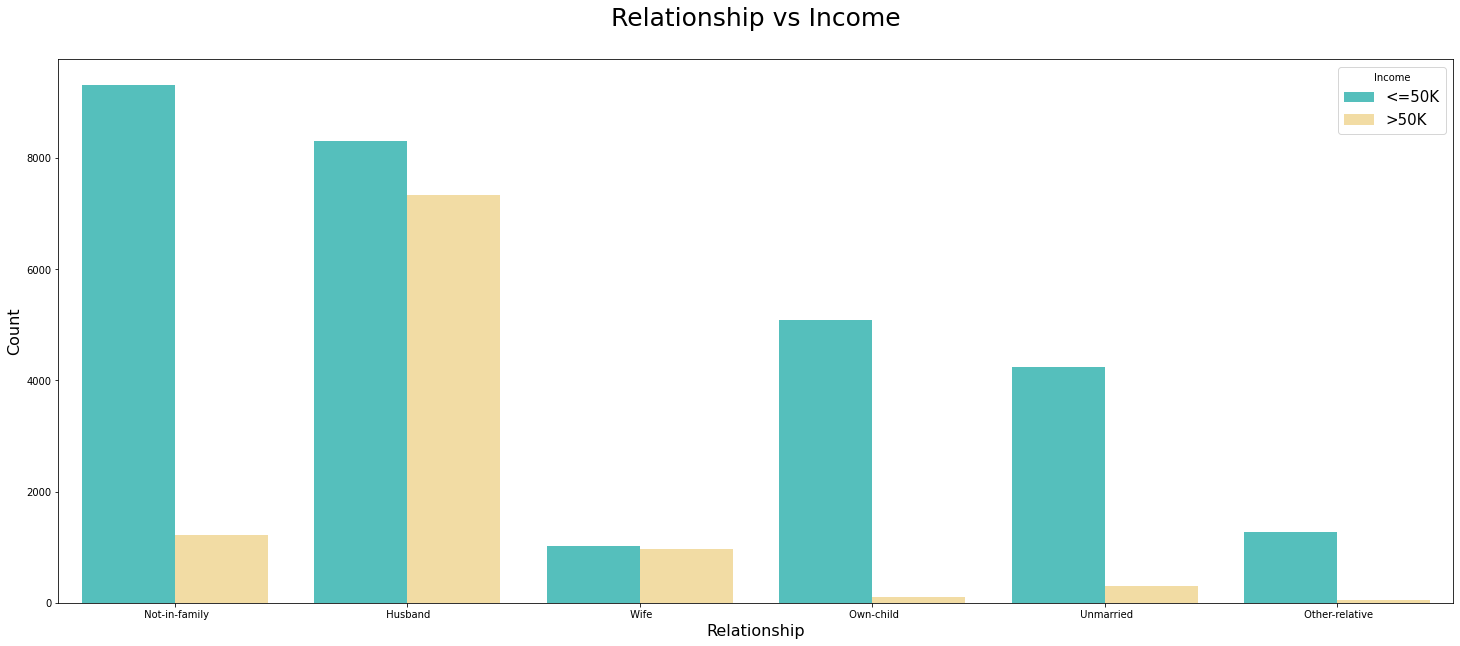

In [ ]:
plt.figure(figsize = (25, 10));
colors = ['#44d0cc','#ffe297','#44d0cc','#ffe297']
sns.countplot('relationship',hue='income',data=data, palette=['#44d0cc','#ffe297'])
plt.title('Relationship vs Income',  fontsize=25, y=1.05)
plt.xlabel('Relationship', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend(title="Income", prop={'size': 15})
plt.show()

*   Apparently, being a husband or a wife is associated with higher income >50k




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


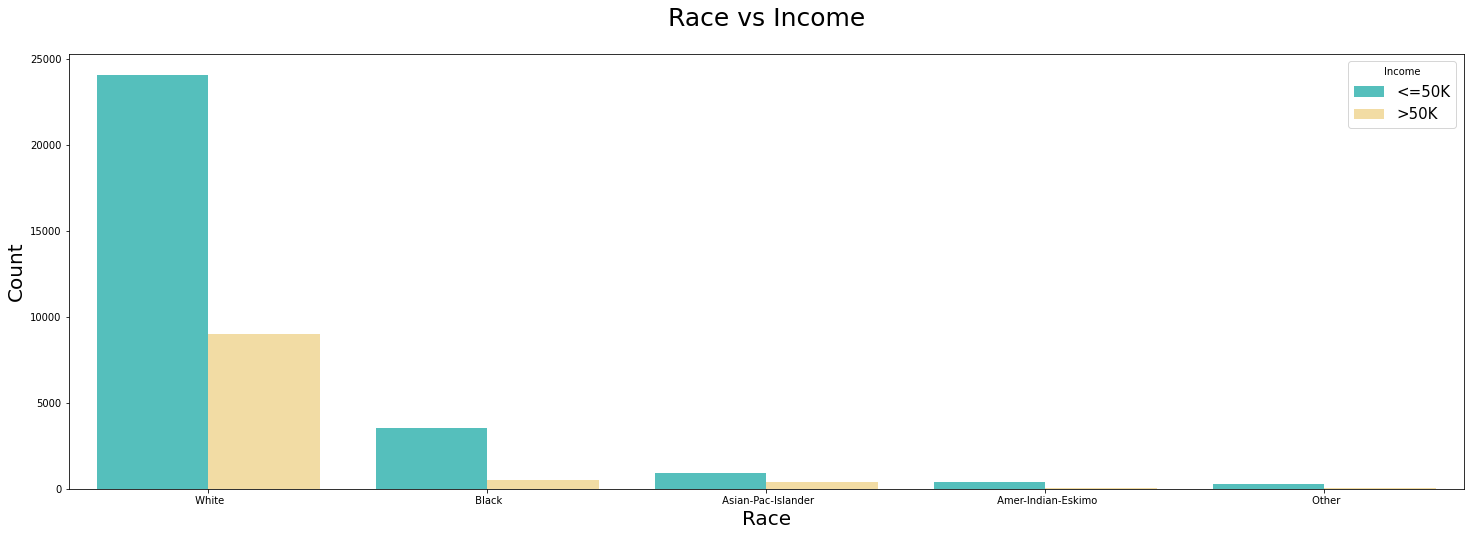

In [ ]:
plt.figure(figsize = (25, 8));
colors = ['#44d0cc','#ffe297','#44d0cc','#ffe297']
sns.countplot('race',hue='income',data=data, palette=['#44d0cc','#ffe297'])
plt.title('Race vs Income',  fontsize=25, y=1.05)
plt.xlabel('Race', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(title="Income", prop={'size': 15})
plt.show()

In [ ]:
grouped = data.groupby(['income','race']).agg(['count']).iloc[:,0]
grouped

income  race               
<=50K    Amer-Indian-Eskimo      382
         Asian-Pac-Islander      930
         Black                  3561
         Other                   308
         White                 24084
>50K     Amer-Indian-Eskimo       53
         Asian-Pac-Islander      369
         Black                   528
         Other                    45
         White                  8980
Name: (age, count), dtype: int64

I will calculate the % manually to save the time for now. 

*   **28.4%** of Asian-Pac-Islander have income of **>50k**
*   **27.15%** of White have income of **>50k**
*   **12.91%** of Black have income of **>50k**
*   **12.18%** of Amer-Indian-Eskimo have income of **>50k**

Here, we can say that **racism is excluded**.



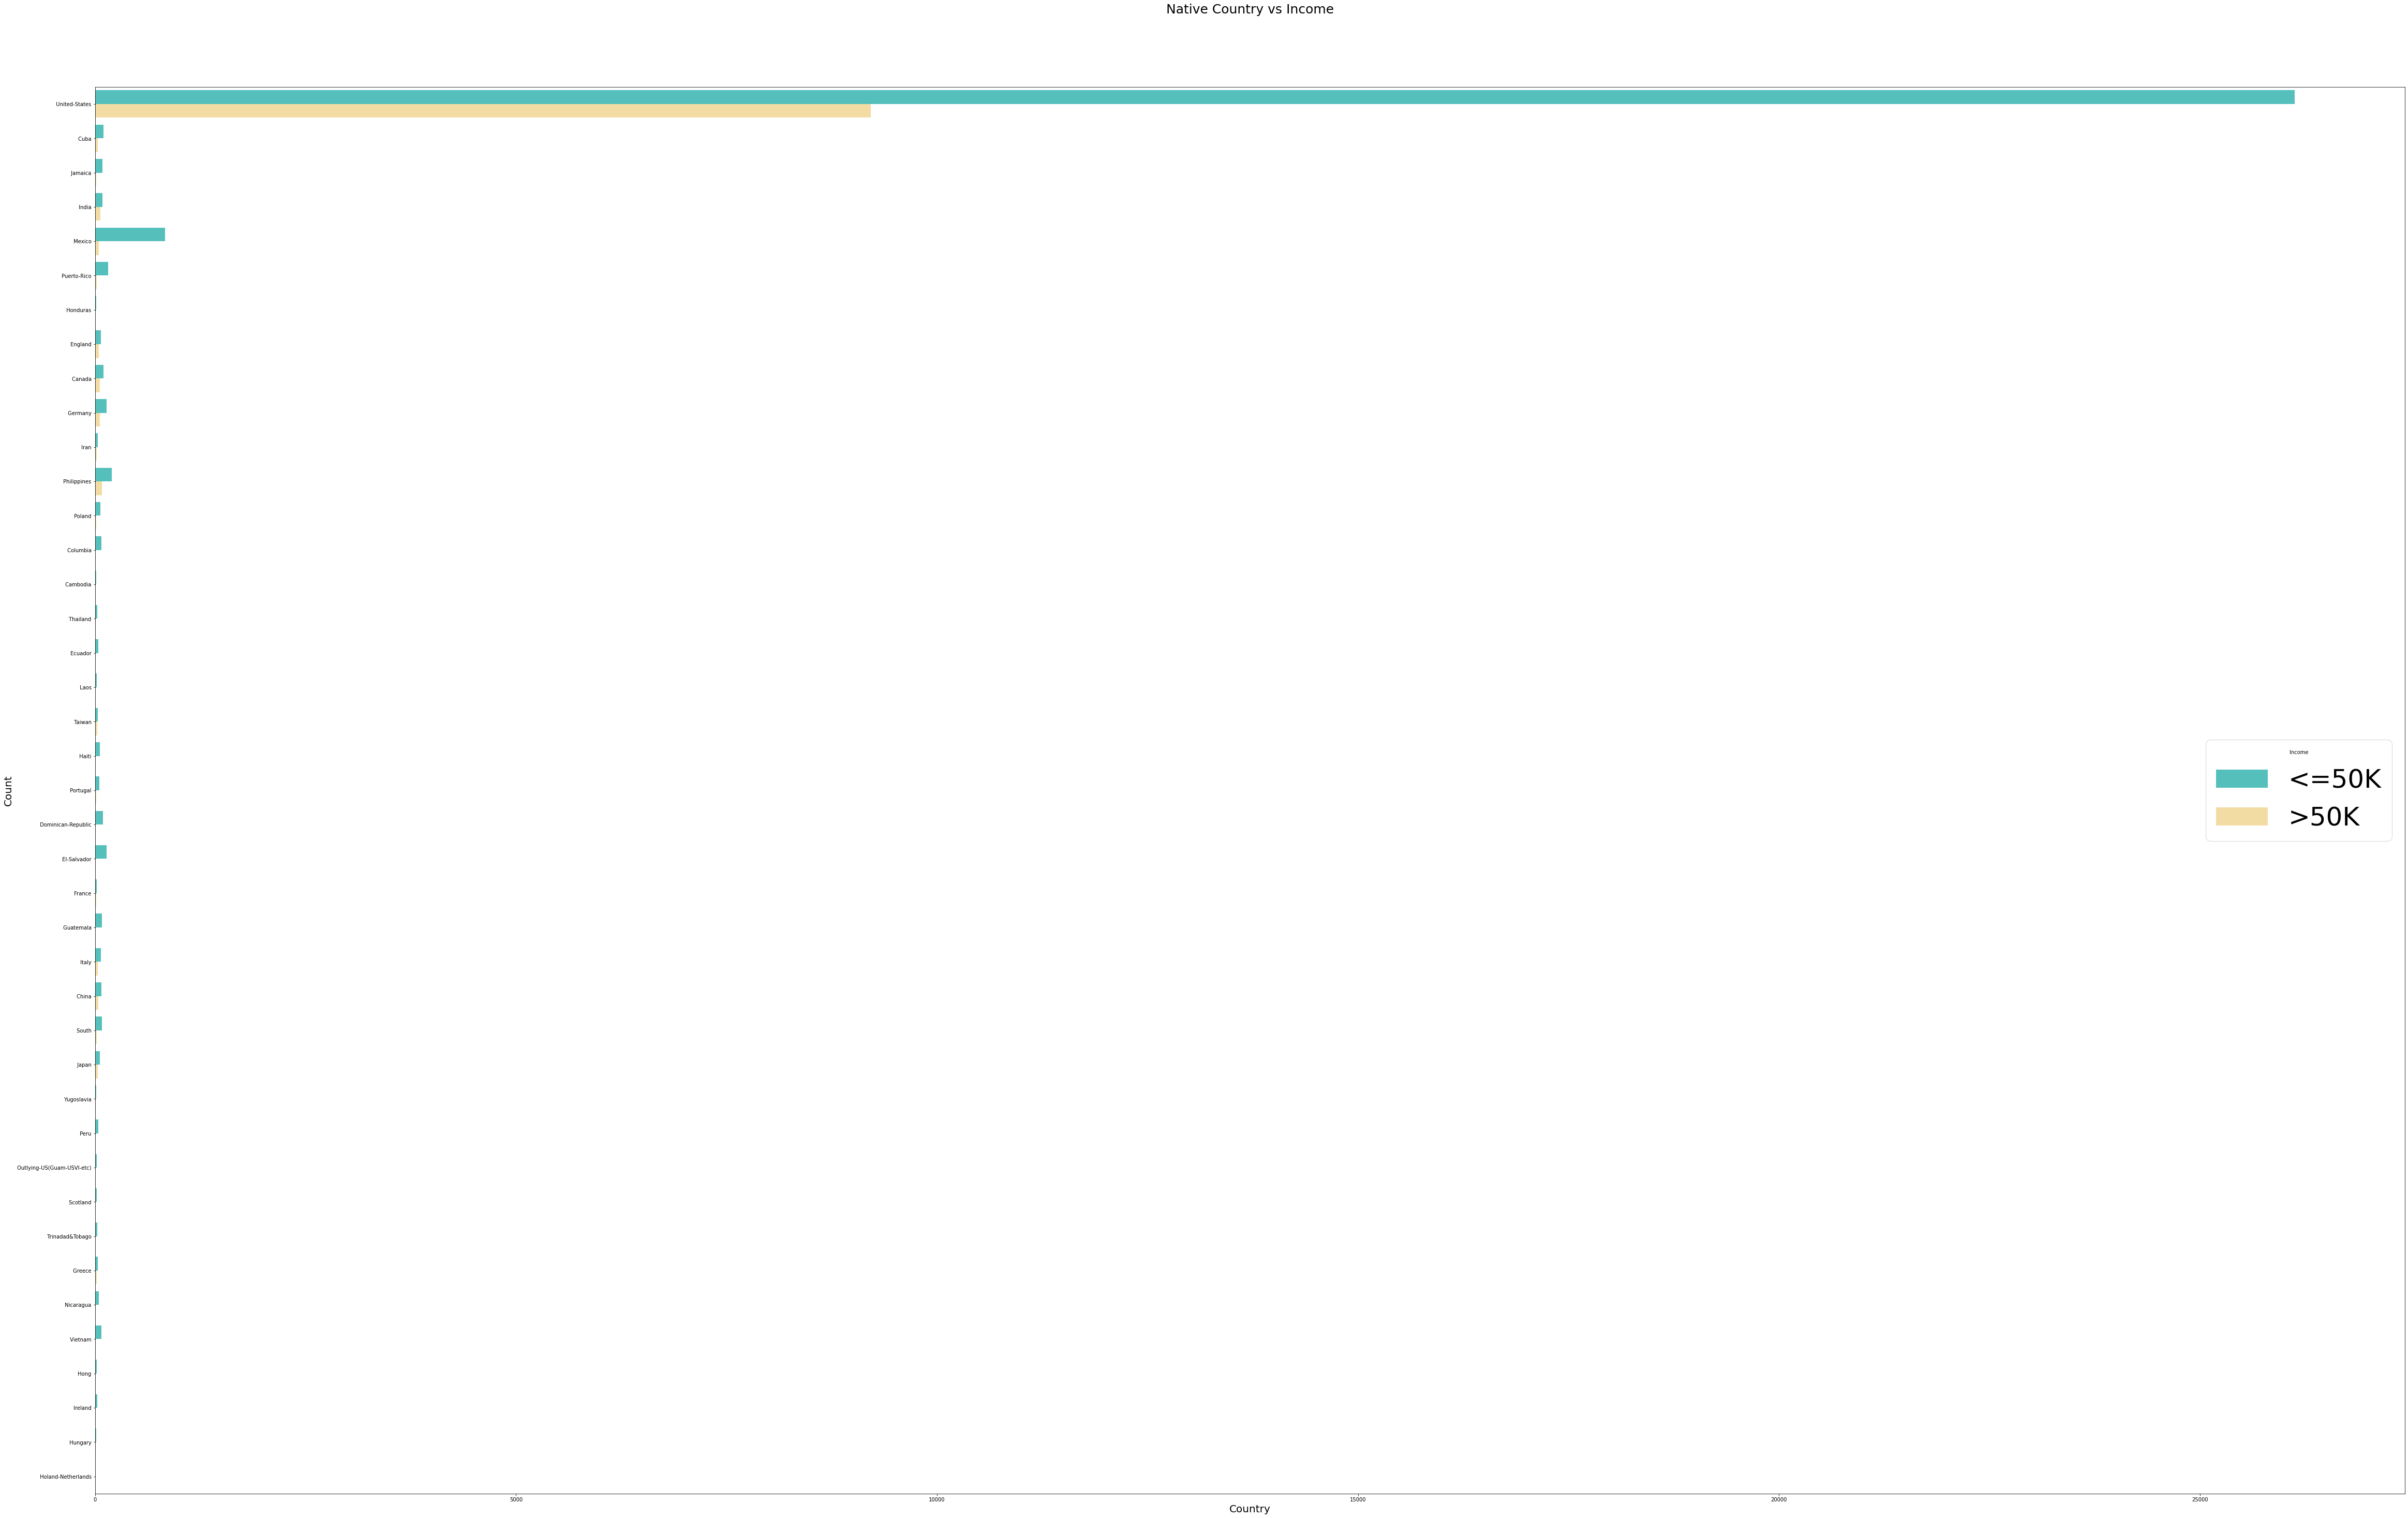

In [ ]:
plt.figure(figsize = (80, 50));
colors = ['#44d0cc','#ffe297','#44d0cc','#ffe297']
sns.countplot(y='native-country',hue='income',data=data, palette=['#44d0cc','#ffe297'])
plt.title('Native Country vs Income',  fontsize=25, y=1.05)
plt.xlabel('Country', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(title="Income", prop={'size': 50})
plt.show()

####Continous features

In [ ]:
numerical_features = [col for col in data.columns if data[col].dtype != 'object']
numerical_features

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

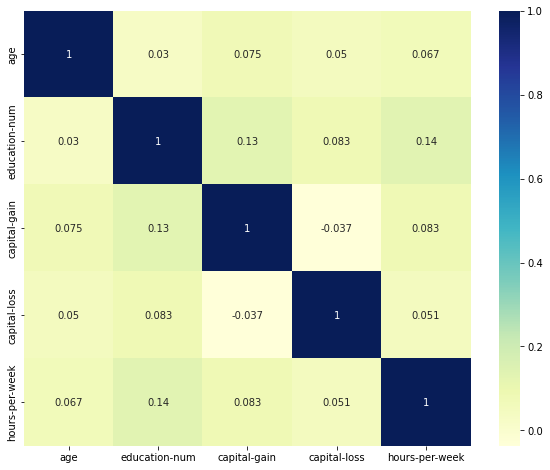

In [ ]:
plt.figure(figsize = (10, 8));
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

### >>> **No** Multicollinearity.

In [ ]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,39240.000000,39240.000000,39240.000000,39240.000000,39240.000000
mean,39.309225,10.136290,1253.314246,101.261340,41.206091
std,13.298041,2.637194,7993.997264,431.434412,12.458021
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,29.000000,9.000000,0.000000,0.000000,40.000000
50%,38.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


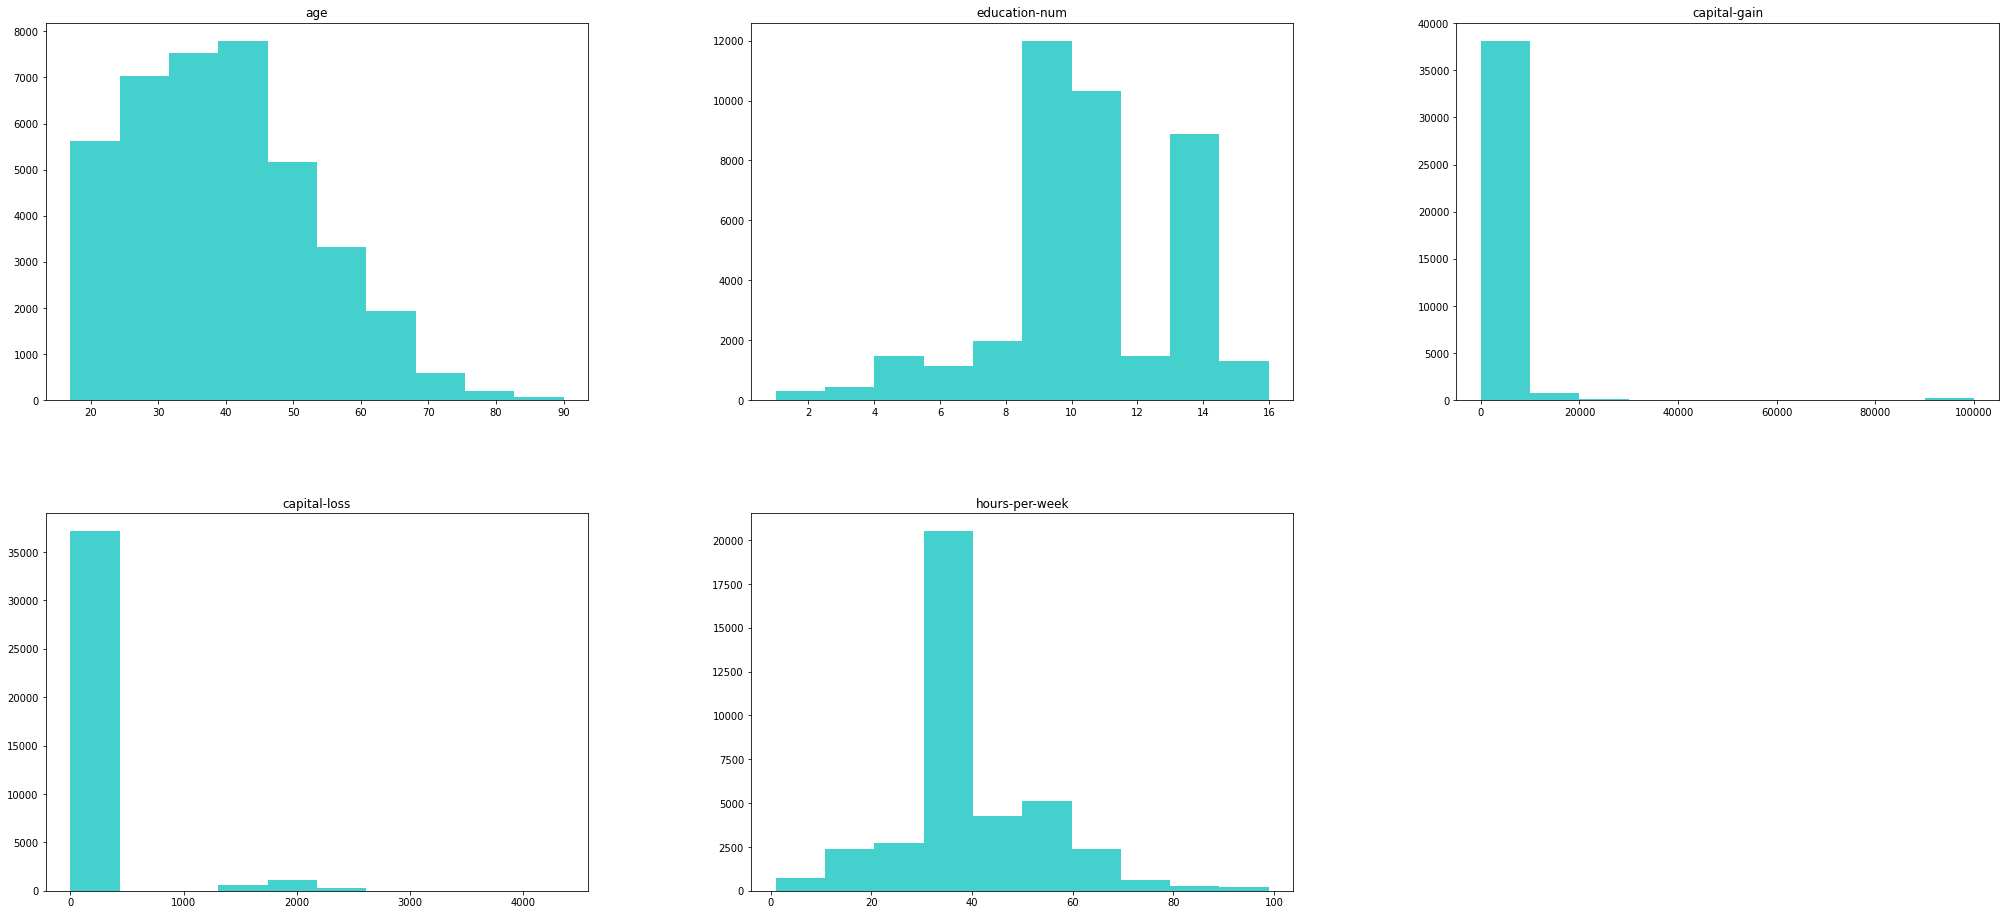

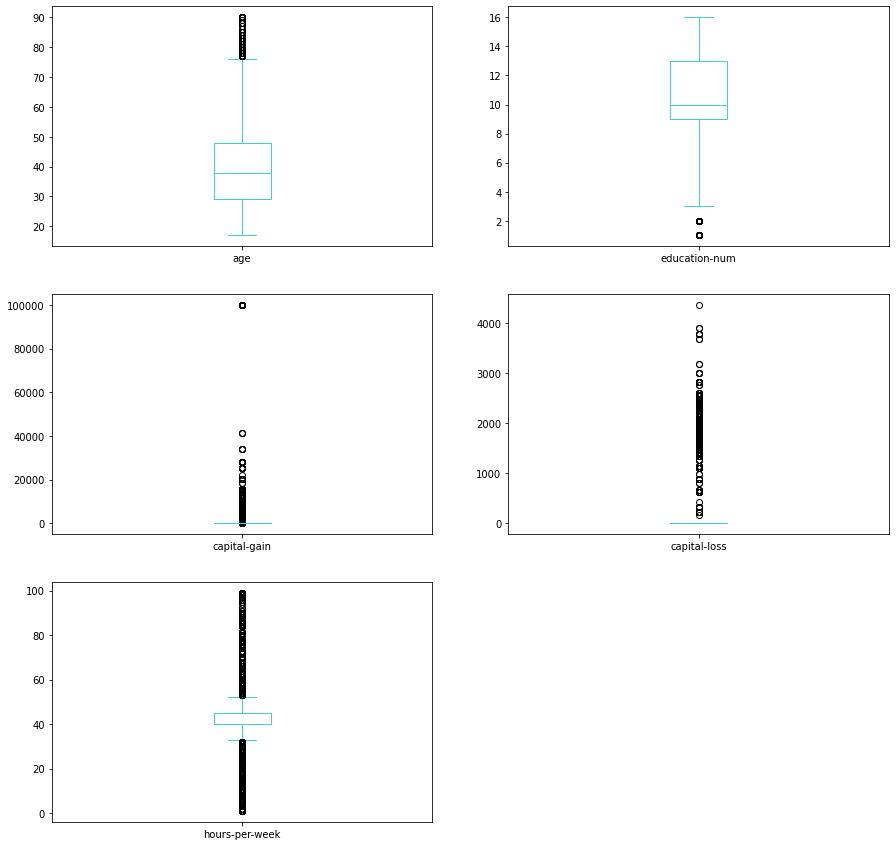

In [ ]:
data.hist(figsize=(35, 25), layout=(3,3), color = '#44d0cc', grid=False);

data.plot(kind='box', figsize=(15, 15), layout=(3,2), color = '#44d0cc', subplots=True);

### Analyzing the plots
There are outlier values, but they all can make sense.

*   **Age** range between 17 and 90
*   **Education-num** refers to educational-level (categorical feature), where each educational number reflects an educational level, so this can be redundant. This can be dealt with by performing feature engineering on **Educational-level**.
* **Capital-gain & Capital-loss** are very far from being normally distributed and they have outliers, can be fixed with **feature engineering**.
* **Hours per week** range from 1 to 99, some extreme values exist but I will leave them as they are.



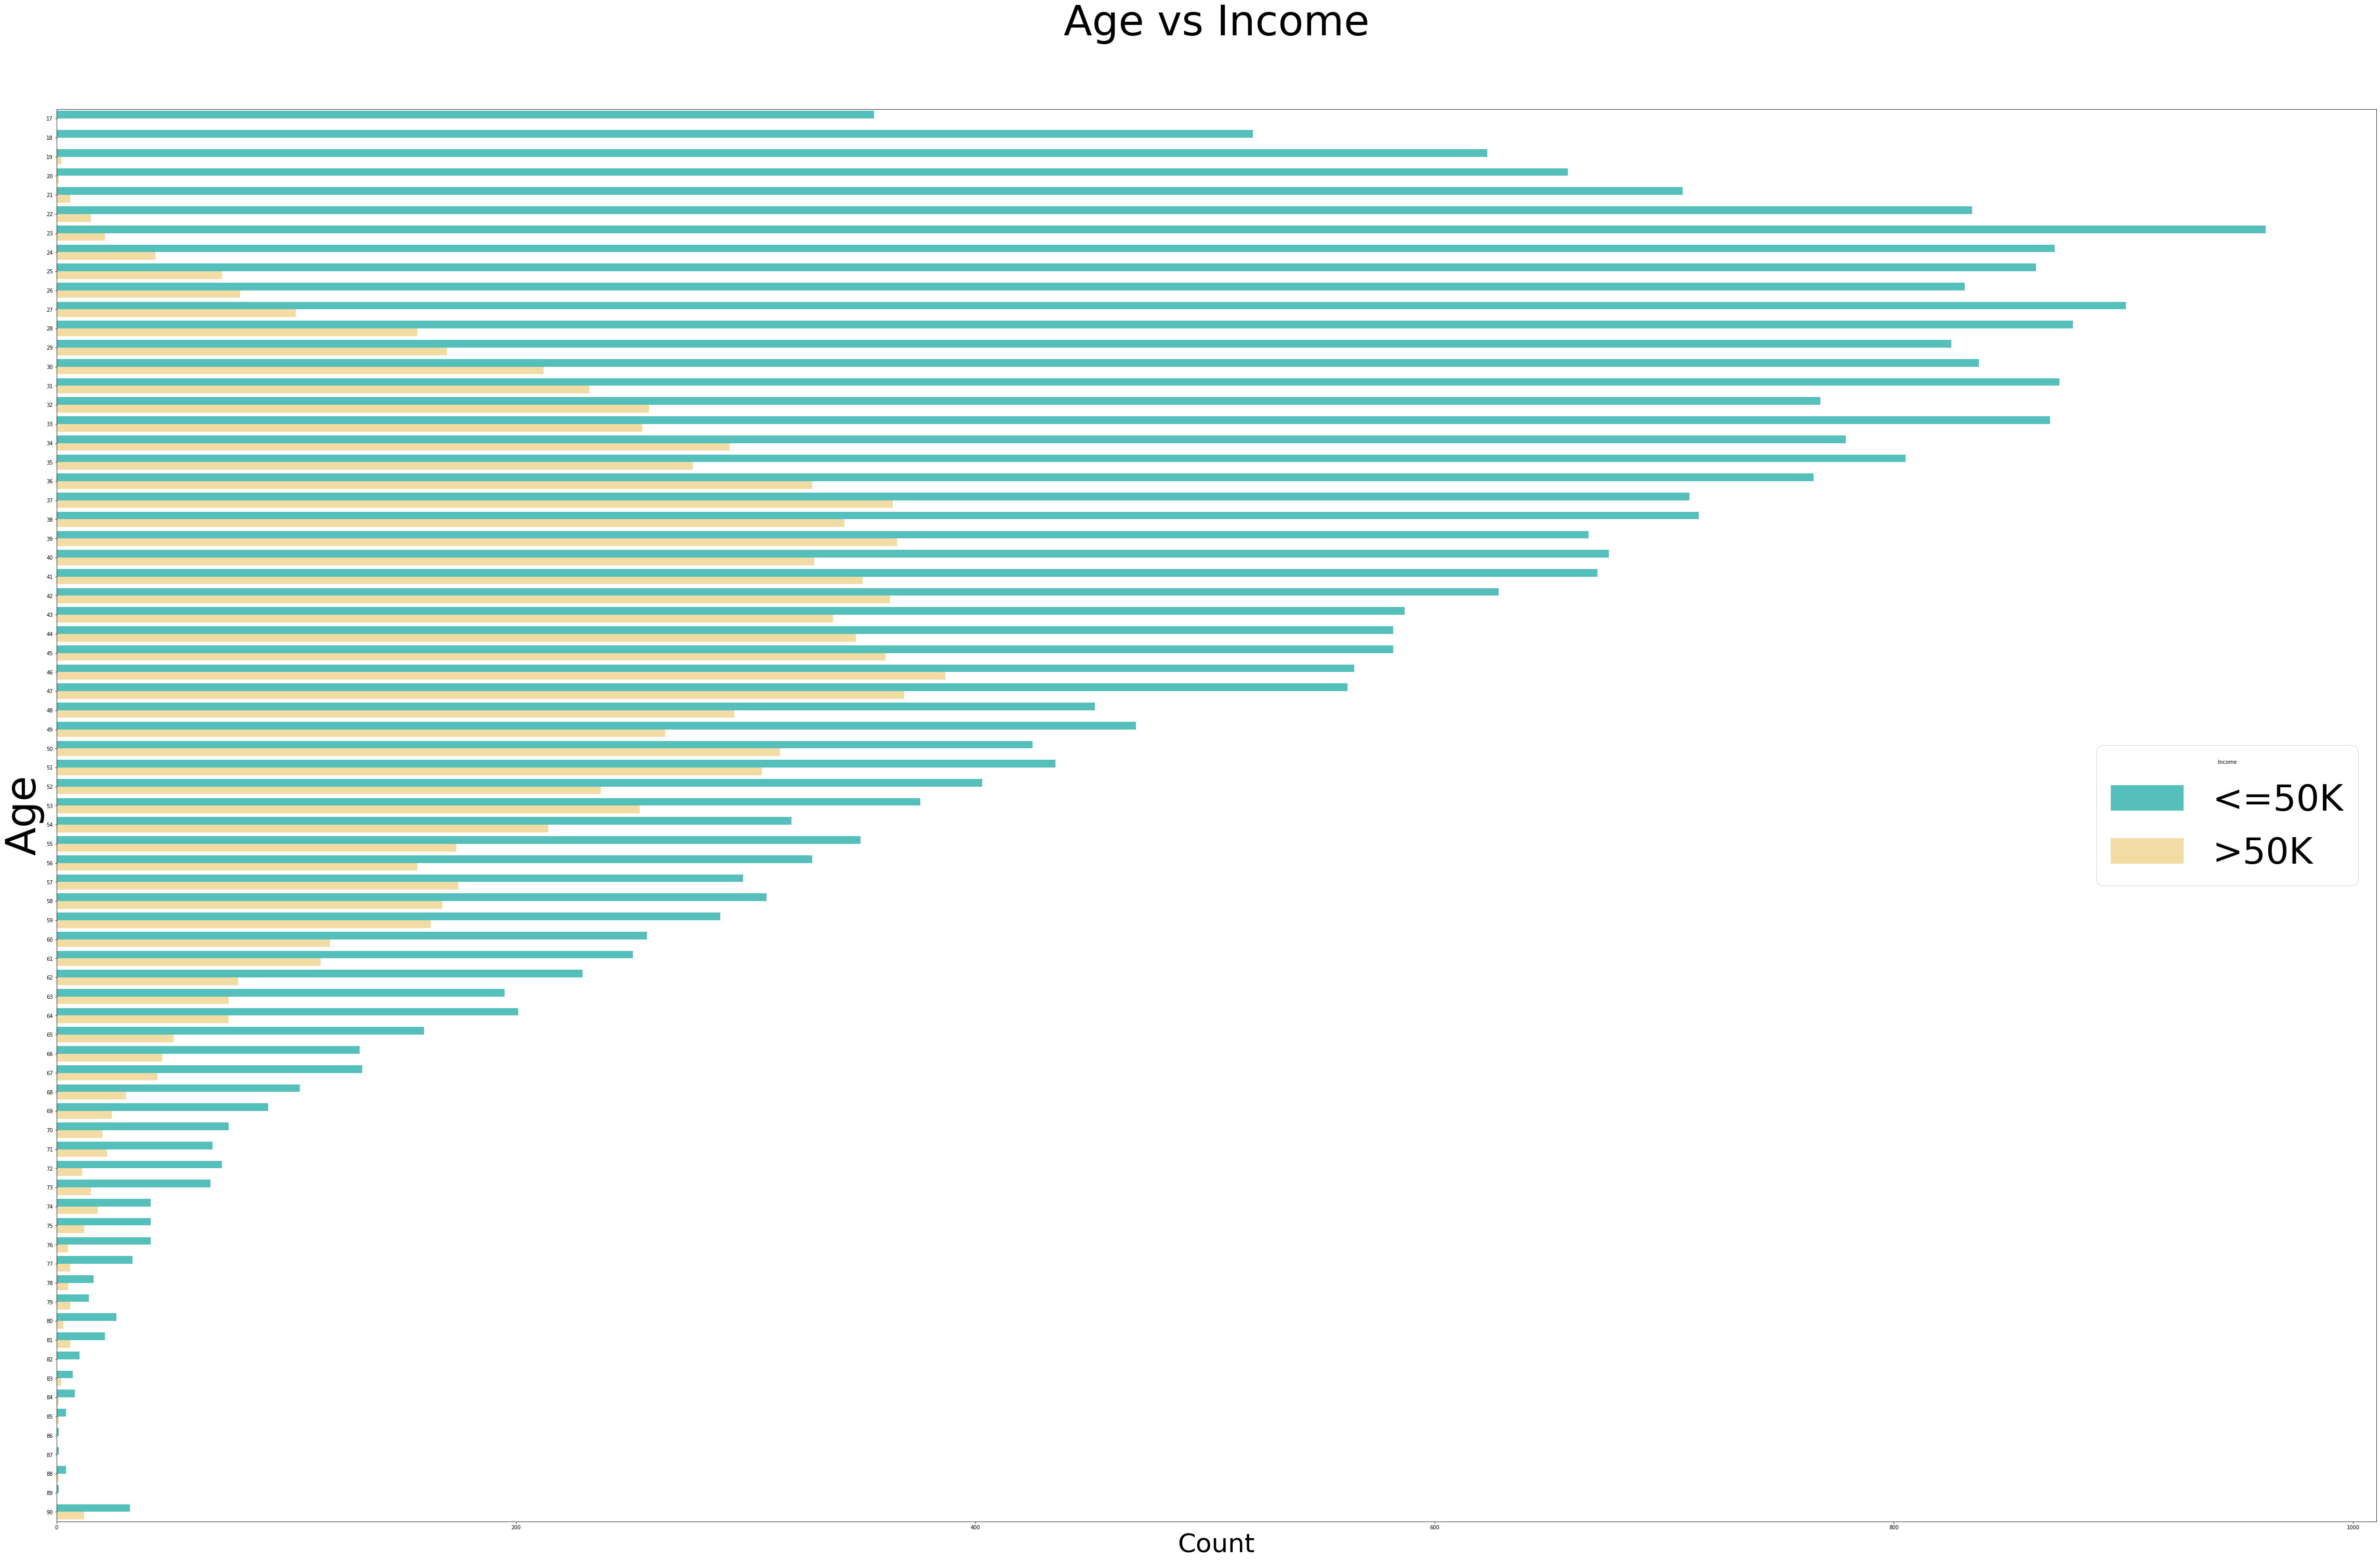

In [ ]:
plt.figure(figsize = (80, 50));
colors = ['#44d0cc','#ffe297','#44d0cc','#ffe297']
sns.countplot(y='age',hue='income',data=data, palette=['#44d0cc','#ffe297'])
plt.title('Age vs Income',  fontsize=80, y=1.05)
plt.xlabel('Count', fontsize=50)
plt.ylabel('Age', fontsize=80)
plt.legend(title="Income", prop={'size': 70})
plt.show()

## This plot is **TOO MUCH!**
We can make age bins later to enhance readability.

But we still can conclude from it that there is a direct positive relationship between age and income.

# Second: Preprocessing

## Feature Engineering

#### Marital Status

In [ ]:
data['marital-status'].value_counts()

 Married-civ-spouse       17947
 Never-married            12169
 Divorced                  5885
 Separated                 1394
 Widowed                   1261
 Married-spouse-absent      552
 Married-AF-spouse           32
Name: marital-status, dtype: int64

In [ ]:
#To remove spaces around values to allow me to do the following step
data['marital-status']= data['marital-status'].str.strip()

In [ ]:
data['marital-status']= data['marital-status'].replace(['Never-married'], 'Single')
data['marital-status']= data['marital-status'].replace(['Married-civ-spouse', 'Married-AF-spouse'], 'Married')
data['marital-status']= data['marital-status'].replace(['Divorced', 'Separated','Widowed',
                                                   'Married-spouse-absent'], 'Other')

In [ ]:
#Checking
data['marital-status'].value_counts()

Married    17979
Single     12169
Other       9092
Name: marital-status, dtype: int64

#### Education Level

In [ ]:
data['education_level'].value_counts()

 HS-grad         12003
 Some-college     8457
 Bachelors        6522
 Masters          2357
 Assoc-voc        1859
 Assoc-acdm       1470
 11th             1422
 10th             1136
 7th-8th           801
 Prof-school       764
 9th               658
 12th              540
 Doctorate         526
 5th-6th           438
 1st-4th           217
 Preschool          70
Name: education_level, dtype: int64

In [ ]:
#To remove spaces around values to allow me to do the following step
data['education_level'] = data['education_level'].str.strip()

In [ ]:
data['education_level'] = data['education_level'].replace(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'high school'], 'School')
#High school grad is left as it is
data['education_level']= data['education_level'].replace(['Assoc-voc', 'Assoc-acdm', 'Some-college'], 'Higher Education')
data['education_level']= data['education_level'].replace('Bachelors', 'Graduates')
data['education_level']= data['education_level'].replace(['Masters', 'Doctorate', 'Prof-school'], 'Post-graduate')

In [ ]:
#Checking
data['education_level'].value_counts()

HS-grad             12003
Higher Education    11786
Graduates            6522
School               5282
Post-graduate        3647
Name: education_level, dtype: int64

#### Capital gain

In [ ]:
data['capital-gain'].value_counts()


0.0        35488
15024.0      486
7688.0       381
7298.0       345
99999.0      226
           ...  
22040.0        1
1639.0         1
2387.0         1
7262.0         1
1731.0         1
Name: capital-gain, Length: 121, dtype: int64

In [ ]:
data['capital-gain'] = data['capital-gain'].apply(lambda x: 'Class 1' if 10000<x
                                                  else 'Class 2' if 0<x<=10000
                                                  else 'Class 3'
                                                  )

In [ ]:
#Checking
data['capital-gain'].value_counts()

Class 3    35488
Class 2     2681
Class 1     1071
Name: capital-gain, dtype: int64

Here I divided Capital gain feature into **3 classes**.

#### Capital loss

In [ ]:
data['capital-loss'].value_counts()

0.0       37117
1902.0      289
1977.0      243
1887.0      224
2415.0       66
          ...  
155.0         1
419.0         1
2080.0        1
4356.0        1
2163.0        1
Name: capital-loss, Length: 97, dtype: int64

In [ ]:
data['capital-loss'] = data['capital-loss'].apply(lambda x: 'Capital loss' if 0<x
                                                  else 'No loss'
                                                   )

In [ ]:
data['capital-loss'].value_counts()

No loss         37117
Capital loss     2123
Name: capital-loss, dtype: int64

Here I divided Capital loss into **2 categories.**

### Target variable

In [ ]:
#To remove spaces around values to allow me to do the following step
data['income'] = data['income'].str.strip()

In [ ]:
#Converting target variable
data['income']= data['income'].replace('<=50K', 0)
data['income']= data['income'].replace('>50K', 1)


In [ ]:
data['income'].unique()

array([0, 1])

In [ ]:
#Checking data after changes
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Graduates,13.0,Single,Adm-clerical,Not-in-family,White,Male,Class 2,No loss,40.0,United-States,0
1,50,Self-emp-not-inc,Graduates,13.0,Married,Exec-managerial,Husband,White,Male,Class 3,No loss,13.0,United-States,0
2,38,Private,HS-grad,9.0,Other,Handlers-cleaners,Not-in-family,White,Male,Class 3,No loss,40.0,United-States,0
3,53,Private,School,7.0,Married,Handlers-cleaners,Husband,Black,Male,Class 3,No loss,40.0,United-States,0
4,28,Private,Graduates,13.0,Married,Prof-specialty,Wife,Black,Female,Class 3,No loss,40.0,Cuba,0


### Encoding Categorical Variables

In [ ]:
data2 = data.copy()

In [ ]:
data2 = pd.get_dummies(data2)

In [ ]:
data2.head()

,age,education-num,hours-per-week,income,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13.0,40.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50,13.0,13.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9.0,40.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7.0,40.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13.0,40.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Scaling

In [ ]:
#Splitting the dataset
X = data2.drop('income', axis = 1)
y = data2['income']

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

# Third: Modeling

### Base Model

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=9)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("Acc on training data: {:,.3f}".format(dt.score(X_train, y_train)))
print("Acc on test data: {:,.3f}".format(dt.score(X_test, y_test)))

Acc on training data: 0.842
Acc on test data: 0.836


Decision tree model led to **overfitting** then I tunned max_depth parameter [3, 5, 7, 9] until I chose 9 and the **overfitting problem was solved**.

### Random Forests

In [ ]:
rfc = RandomForestClassifier(max_depth=17)

model1 = rfc.fit(X_train, y_train)
prediction1 = model1.predict(X_test)

print("Acc on training data: {:,.3f}".format(rfc.score(X_train, y_train)))
print("Acc on test data: {:,.3f}".format(rfc.score(X_test, y_test)))

Acc on training data: 0.885
Acc on test data: 0.849


It overfitted but after adjusting the max_depth the problem was solved.

### Logistic Regression

In [ ]:
lr = LogisticRegression()
cv_score = cross_val_score(lr, X_train, y_train,
                          cv = 10,
                          scoring = 'accuracy')
cv_score.mean()

0.8380477372200568


In [ ]:
model = lr.fit(X_train, y_train)
prediction = model.predict(X_test)

print("Acc on training data: {:,.3f}".format(lr.score(X_train, y_train)))
print("Acc on test data: {:,.3f}".format(lr.score(X_test, y_test)))

Acc on training data: 0.840
Acc on test data: 0.846


### K-Nearest Neighbours(KNN)

In [ ]:
model=KNeighborsClassifier() 
cv_score = cross_val_score(model, X_train, y_train,
                          cv = 10,
                          scoring = 'accuracy')
cv_score.mean()

0.811098092012751

In [ ]:
model.fit(X_train, y_train)
prediction5=model.predict(X_test)
print("Acc on training data: {:,.3f}".format(model.score(X_train, y_train)))
print("Acc on test data: {:,.3f}".format(model.score(X_test, y_test)))

Acc on training data: 0.867
Acc on test data: 0.821


I adjusted **n-neighbors** parameter to be 9, this enhanced the accuracy a little.

### XGBoost

In [ ]:
gb = xgb.XGBClassifier()
cv_score = cross_val_score(gb, X_train, y_train,
                          cv = 10,
                          scoring = 'accuracy')
cv_score.mean()

0.8414560907262851

In [ ]:
gb1 = gb.fit(X_train, y_train)
prediction1 = model1.predict(X_test)

print("Acc on training data: {:,.3f}".format(gb1.score(X_train, y_train)))
print("Acc on test data: {:,.3f}".format(gb1.score(X_test, y_test)))

Acc on training data: 0.845
Acc on test data: 0.851


## Confusion Matrix

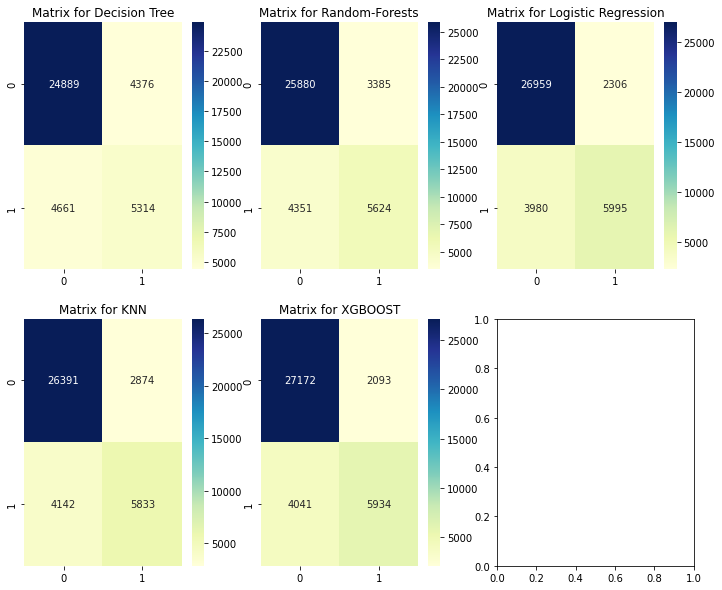

In [ ]:
f,ax=plt.subplots(2,3,figsize=(12,10))
y_pred = cross_val_predict(DecisionTreeClassifier(),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[0,0],annot=True, cmap="YlGnBu", fmt='2.0f')
ax[0,0].set_title('Matrix for Decision Tree')

y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[0,1],annot=True, cmap="YlGnBu", fmt='2.0f')
ax[0,1].set_title('Matrix for Random-Forests')

y_pred = cross_val_predict(LogisticRegression(),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[0,2],annot=True, cmap="YlGnBu", fmt='2.0f')
ax[0,2].set_title('Matrix for Logistic Regression')

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[1,0],annot=True, cmap="YlGnBu", fmt='2.0f')
ax[1,0].set_title('Matrix for KNN')

y_pred = cross_val_predict(xgb.XGBClassifier(),X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=ax[1,1],annot=True,cmap="YlGnBu", fmt='2.0f')
ax[1,1].set_title('Matrix for XGBOOST')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

**Why Confusion Matrix?**

If we assumed that I am analyzing this data for a bank and want to estimate how many of the clients who took loans will fall in default based on the correct prediction of their income. 

(**Of course** banks have other criteria, I am just assuming.)

Then measuring accuracy won't be sufficient here. It's better to use Confusion matrix here where we can keep count of False Positives (What concerns me), where we can depend on the model with the least False Positive; in other worda, least precision. 

Since the actual is on the x-axis and the predict is on the y-axis, therefore the false positive cell is the on the bottom left.

# Fourth: Conclusion
**Logistic regression** is the model of choice despite the fact that XGBOOST has slightly better performance than it.

**Future Enhancements:**

*   Implementing **RandomForest Classifier** to detect **important features.**
*   Using **GridSearch** to tune hyperparameters.
*   Correcting **imbalanced** target variable after performing cross-validation using **oversampling**; duplicating data or using SMOTE technique.
*   Putting effort into building a pipeline.